In [1]:
from keras.layers import Input, Bidirectional, LSTM, Dense, Dropout
from keras.layers.merge import multiply, concatenate, subtract
from keras.models import Model, load_model
from libaries.attention import AttentionLayer
from keras.utils import plot_model
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import random
import pickle
import pandas
import time
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Train model and parameters otimization
Our goal here is to create a way to esily train hyperparameters. For that, we'll create a set of functions

In [2]:
#Import data

#train
wordsInputTrain = pickle.load(open("binaries/wordsInputTrain.pkl", 'rb'))
documentsPostInputTrain = pickle.load(open("binaries/documentsPostInputTrain.pkl", 'rb'))
documentsTargetInputTrain = pickle.load(open("binaries/documentsTargetInputTrain.pkl", 'rb'))
imagesInputTrain = pickle.load(open("binaries/imagesInputTrain.pkl", 'rb'))
outputTrain = pickle.load(open("binaries/outputTrain.pkl", 'rb'))
trainIndexes = pickle.load(open("binaries/trainIndexes.pkl", 'rb'))

#test
wordsInputTest = pickle.load(open("binaries/wordsInputTest.pkl", 'rb'))
documentsPostInputTest = pickle.load(open("binaries/documentsPostInputTest.pkl", 'rb'))
documentsTargetInputTest = pickle.load(open("binaries/documentsTargetInputTest.pkl", 'rb'))
imagesInputTest = pickle.load(open("binaries/imagesInputTest.pkl", 'rb'))
outputTest = pickle.load(open("binaries/outputTest.pkl", 'rb'))
testIndexes = pickle.load(open("binaries/testIndexes.pkl", 'rb'))


In [3]:
#Parameters to optimize
params = {
    "droupoutRate" : [0, 0.2, 0.5],
    "lActivation" : ["relu", "tanh", "sigmoid", "softmax"],
    "optimizer" : ["adadelta", "rmsprop", "adam", "adagrad"],
    "loss" : ["binary_crossentropy", "logcosh"],
    "comparison" : ["subtract", "multiply"],
    "epochs" : [5, 10, 15],
    "images" : [True, False]
    }

In [4]:
#Create metrics not present in keras
#we had to compute them manually

def recallM(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precisionM(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1M(y_true, y_pred):
    precision = precisionM(y_true, y_pred)
    recall = recallM(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [5]:
#Create the actual model structure
#dependent on the params

#general static parameters
words = 20
wordEmbeddingSize = 300

def createModel(param):

    #general parameters
    droupoutRate=param["droupoutRate"]
    lActivation = param["lActivation"]
    hiddenSize1=128
    hiddenSize2=64
    hiddenSize3=32

    # Words Component  

    wordsInput = Input(shape=(words, wordEmbeddingSize))
    wLstm1 = Bidirectional(LSTM(hiddenSize1, return_sequences=True))(wordsInput)
    wLstm2 = Bidirectional(LSTM(hiddenSize2, return_sequences=True))(wLstm1)
    wLstm3 = Bidirectional(LSTM(hiddenSize3, return_sequences=True))(wLstm2)
    wAttention = AttentionLayer()(wLstm3)
    wDropout1 = Dropout(droupoutRate)(wAttention)
    wHidden1 = Dense(hiddenSize1, activation=lActivation)(wDropout1)
    wDropout2 = Dropout(droupoutRate)(wHidden1)
    wordsOutput= Dense(hiddenSize2, activation=lActivation)(wDropout2)

    # Documents component

    documentsPostInput = Input(shape=(wordEmbeddingSize, ))
    documentsTargetInput = Input(shape=(wordEmbeddingSize, ))

    postHidden1 = Dense(hiddenSize1, activation=lActivation)(documentsPostInput)
    targetHidden1 = Dense(hiddenSize1, activation=lActivation)(documentsTargetInput)

    postHidden2 = Dense(hiddenSize2, activation=lActivation)(postHidden1)
    targetHidden2 = Dense(hiddenSize2, activation=lActivation)(targetHidden1)

    postHidden3 = Dense(hiddenSize3, activation=lActivation)(postHidden2)
    targetHidden3 = Dense(hiddenSize3, activation=lActivation)(targetHidden2)

    if param["comparison"] == "multiply":
        documentsPostOutput = multiply([postHidden3, targetHidden3])
    elif param["comparison"] == "subtract":
        documentsPostOutput = subtract([postHidden3, targetHidden3])
    else: #if not specified or unknown do subtraction
        documentsPostOutput = subtract([postHidden3, targetHidden3])



    # Images Component
    if param["images"]:

        iImageSize = 1000

        imagesInput = Input(shape=(iImageSize,))

        imagesHidden1 = Dense(hiddenSize1, activation= lActivation)(imagesInput)
        imagesHidden2 = Dense(hiddenSize2, activation= lActivation)(imagesHidden1)
        imagesHidden3 = Dense(hiddenSize3, activation= lActivation)(imagesHidden2)

        imagesOutput = imagesHidden3

    # Combine the 3 components

    fActivation = "sigmoid"
    gHiddenSize = 32

    if param["images"]:
        gCombined = concatenate([wordsOutput, documentsPostOutput, imagesOutput])
    else:
        gCombined = concatenate([wordsOutput, documentsPostOutput])
    gDropout = Dropout(droupoutRate)(gCombined)
    gHidden = Dense(gHiddenSize, activation=lActivation)(gDropout)

    # Output
    output = Dense(1, activation=fActivation)(gHidden)

    # Model
    optimizer=param["optimizer"]
    loss=param["loss"]
    metrics=["mean_squared_error", "accuracy", f1M, precisionM, recallM]

    if param["images"]:
        inputs = [wordsInput, documentsPostInput, documentsTargetInput, imagesInput]
    else:
        inputs = [wordsInput, documentsPostInput, documentsTargetInput]

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

In [6]:
#Method to create an output dataframe from the model, with all relevant information
def createOutputDf(model, x_test, y_test, param, df=None):
    score = model.evaluate(x_test, y_test, verbose=1)
    metrics={}
    for i, name in enumerate(model.metrics_names):
        metrics[name]=score[i]

    if df is None:
        df = pandas.DataFrame()

    newLine = dict(metrics)
    newLine.update(param)
    newLine.update(model.optimizer.get_config())
    return df.append(newLine, ignore_index=True)

In [7]:
#general function that aggregates model creation, model fit and creation of dataframe
def click_Bait_Model(x_train, y_train, x_test, y_test, param, i, df=None):

    print("-----------------------------------")
    print("Creating model " + str(i+1) + " ...")
    model = createModel(param)

    print("Fitting model ...")
    #fit does not return best model! We need checkpoint to get the best one
    checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)
    fit = model.fit(x_train, y_train, validation_split=0.2, epochs=param["epochs"], verbose=2, callbacks=[checkpointer])
    #load best weights
    model.load_weights('weights.hdf5')

    print("Evaluate model ...")
    outputDf = createOutputDf(model, x_test, y_test, param, df)

    return model, fit, outputDf


In [8]:
#generate random combination of given parameters
def generateRandomCombination(params):
    param = {}
    for key in params:
        param[key]=random.choice(params[key])
    return param

In [9]:
#run n models with the given parameters
def runModels(n, params):
    print("Starting...")
    models = []
    df = pandas.DataFrame()
    for i in range(n):
        param=generateRandomCombination(params)
        
        #set inputs. With or without images
        inputTrain = [wordsInputTrain, documentsPostInputTrain, documentsTargetInputTrain]
        inputTest = [wordsInputTest, documentsPostInputTest, documentsTargetInputTest]
        if param["images"]:
            inputTrain.append(imagesInputTrain)
            inputTest.append(imagesInputTest)

        m,f,df = click_Bait_Model(inputTrain, outputTrain, inputTest, outputTest, param, i, df)
        f.model=None
        models.append({"model":m,"fit":f})
        pickle.dump(df, open("binaries/odf.pkl", 'wb')) # in case something fails we save to disk
        m.save("binaries\model"+ str(i) + str(random.getrandbits(32)) +".h5") # in case something fails we save to disk
    print("-----------------------------------")
    print("Finished.")
    return models, df

# TRAIN MODEL - 1st ROUND

In [36]:
start_time = time.time()
models, odf = runModels(12, params)
print("--- %s seconds ---" % (time.time() - start_time))

d_error: 0.1215 - val_accuracy: 0.8432 - val_f1M: 0.6593 - val_precisionM: 0.7008 - val_recallM: 0.6519

Epoch 00004: val_loss did not improve from 0.05246
Epoch 5/15
 - 27s - loss: 0.0388 - mean_squared_error: 0.0852 - accuracy: 0.8914 - f1M: 0.7433 - precisionM: 0.8221 - recallM: 0.7130 - val_loss: 0.0599 - val_mean_squared_error: 0.1339 - val_accuracy: 0.8352 - val_f1M: 0.6586 - val_precisionM: 0.6636 - val_recallM: 0.6782

Epoch 00005: val_loss did not improve from 0.05246
Epoch 6/15
 - 28s - loss: 0.0336 - mean_squared_error: 0.0740 - accuracy: 0.9048 - f1M: 0.7785 - precisionM: 0.8502 - recallM: 0.7491 - val_loss: 0.0597 - val_mean_squared_error: 0.1333 - val_accuracy: 0.8359 - val_f1M: 0.6090 - val_precisionM: 0.7268 - val_recallM: 0.5516

Epoch 00006: val_loss did not improve from 0.05246
Epoch 7/15
 - 28s - loss: 0.0285 - mean_squared_error: 0.0631 - accuracy: 0.9223 - f1M: 0.8137 - precisionM: 0.8802 - recallM: 0.7875 - val_loss: 0.0644 - val_mean_squared_error: 0.1438 - val_

In [58]:
odf

,accuracy,comparison,decay,droupoutRate,epochs,epsilon,f1M,images,lActivation,learning_rate,loss,mean_squared_error,optimizer,precisionM,recallM,rho,amsgrad,beta_1,beta_2
0,0.755544,multiply,0.0,0.2,10.0,1.000000e-07,0.000000,0.0,softmax,1.000,binary_crossentropy,0.184698,adadelta,0.000000,0.000000,0.95,NaN,NaN,NaN
1,0.824804,multiply,0.0,0.2,10.0,1.000000e-07,0.503234,1.0,relu,0.001,binary_crossentropy,0.120760,adam,0.733534,0.408854,NaN,0.0,0.9,0.999
2,0.755544,multiply,0.0,0.5,10.0,1.000000e-07,0.000000,0.0,softmax,1.000,binary_crossentropy,0.184697,adadelta,0.000000,0.000000,0.95,NaN,NaN,NaN
3,0.831286,multiply,0.0,0.5,15.0,1.000000e-07,0.580816,0.0,relu,0.010,logcosh,0.122482,adagrad,0.697385,0.525742,NaN,NaN,NaN,NaN
4,0.827533,subtract,0.0,0.0,10.0,1.000000e-07,0.620885,0.0,sigmoid,0.001,logcosh,0.120441,adam,0.646165,0.630801,NaN,0.0,0.9,0.999
5,0.755544,multiply,0.0,0.5,10.0,1.000000e-07,0.000000,0.0,softmax,1.000,logcosh,0.185386,adadelta,0.000000,0.000000,0.95,NaN,NaN,NaN
6,0.835892,subtract,0.0,0.2,10.0,1.000000e-07,0.619896,0.0,sigmoid,0.001,logcosh,0.120225,adam,0.684195,0.595894,NaN,0.0,0.9,0.999
7,0.755544,multiply,0.0,0.0,15.0,1.000000e-07,0.000000,1.0,softmax,1.000,binary_crossentropy,0.184887,adadelta,0.000000,0.000000,0.95,NaN,NaN,NaN
8,0.787103,subtract,0.0,0.0,15.0,1.000000e-07,0.486027,1.0,softmax,0.001,logcosh,0.148267,adam,0.572481,0.452467,NaN,0.0,0.9,0.999
9,0.829580,subtract,0.0,0.2,5.0,1.000000e-07,0.613664,0.0,tanh,0.001,logcosh,0.123065,adam,0.655437,0.606577,NaN,0.0,0.9,0.999


In [ ]:
models

In [114]:
odf["models"] = models

## Analyse parameters

In [63]:
#CORRELATION - numeric
#keep only numeric to do correlation
ndf = fodf.dropna(axis='columns').drop(columns=["epsilon", "decay", "accuracy", "precisionM", "f1M", "recallM"])
cor = ndf.corr()
cor["mean_squared_error"].sort_values()

epochs               -0.203429
images                0.080059
droupoutRate          0.184118
learning_rate         0.557924
mean_squared_error    1.000000
Name: mean_squared_error, dtype: float64

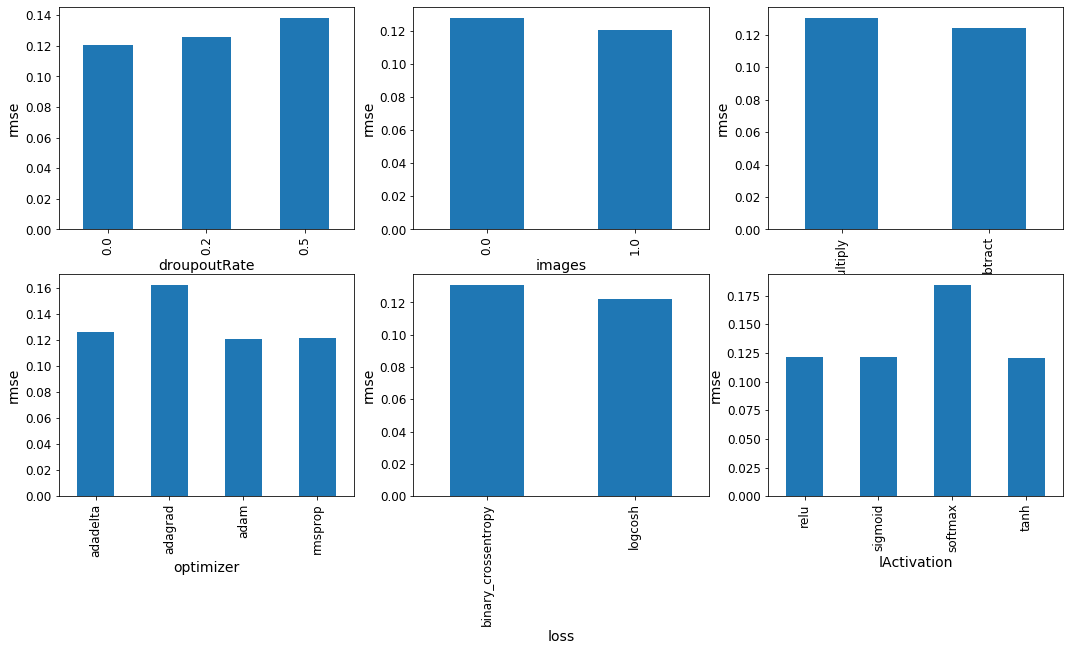

In [68]:
features=["droupoutRate", "images", "comparison", "optimizer", "loss", "lActivation"]
fig, ax = plt.subplots(2,3,figsize=(18,9))

ndf = odf_novo.groupby(features[0]).mean()["mean_squared_error"]
ndf.plot.bar(ax=ax[0,0])
ax[0,0].set_xlabel(features[0], fontsize = 14)
ax[0,0].set_ylabel("rmse", fontsize = 14)

ndf = odf_novo.groupby(features[1]).mean()["mean_squared_error"]
ndf.plot.bar(ax=ax[0,1])
ax[0,1].set_xlabel(features[1], fontsize = 14)
ax[0,1].set_ylabel("rmse", fontsize = 14)

ndf = odf_novo.groupby(features[2]).mean()["mean_squared_error"]
ndf.plot.bar(ax=ax[0,2])
ax[0,2].set_xlabel(features[2], fontsize = 14)
ax[0,2].set_ylabel("rmse", fontsize = 14)

ndf = odf_novo.groupby(features[3]).mean()["mean_squared_error"]
ndf.plot.bar(ax=ax[1,0])
ax[1,0].set_xlabel(features[3], fontsize = 14)
ax[1,0].set_ylabel("rmse", fontsize = 14)

ndf = odf_novo.groupby(features[4]).mean()["mean_squared_error"]
ndf.plot.bar(ax=ax[1,1])
ax[1,1].set_xlabel(features[4], fontsize = 14)
ax[1,1].set_ylabel("rmse", fontsize = 14)

ndf = odf_novo.groupby(features[5]).mean()["mean_squared_error"]
ndf.plot.bar(ax=ax[1,2])
ax[1,2].set_xlabel(features[5], fontsize = 14)
ax[1,2].set_ylabel("rmse", fontsize = 14)

plt.rcParams.update({'font.size': 12})

plt.show()

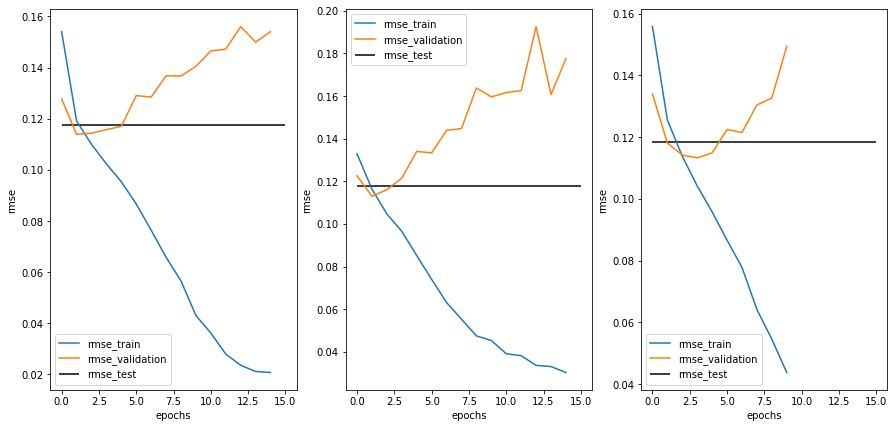

In [131]:
fig, ax = plt.subplots(1,3,figsize=(15,7))
for ind in range(0,3):
    ax[ind].plot(fodf.iloc[ind,:]["models"]["fit"].history['mean_squared_error'], label="rmse_train")
    ax[ind].plot(fodf.iloc[ind,:]["models"]["fit"].history['val_mean_squared_error'], label="rmse_validation")
    ax[ind].hlines(fodf.iloc[ind,:]["mean_squared_error"], 0,15, label="rmse_test")
    ax[ind].set_xlabel("epochs")
    ax[ind].set_ylabel("rmse")
    ax[ind].legend()
plt.show()

# TRAIN MODEL - 2nd ROUND

In [ ]:
#We decided to change the parameters according to the previous analysis

In [10]:
params = {
    "droupoutRate" : [0, 0.2],
    "lActivation" : ["relu", "tanh", "sigmoid"],
    "optimizer" : ["rmsprop", "adam"],
    "loss" : ["binary_crossentropy", "logcosh"],
    "comparison" : ["subtract"],
    "epochs" : [2,3,4,5],
    "images" : [True, False]
    }

In [12]:
start_time = time.time()
nfmodels, nodf = runModels(18, params)
print("--- %s seconds ---" % (time.time() - start_time))

isionM: 0.7804 - val_recallM: 0.5083

Epoch 00001: val_loss improved from inf to 0.05801, saving model to weights.hdf5
Epoch 2/3
 - 21s - loss: 0.0527 - mean_squared_error: 0.1143 - accuracy: 0.8421 - f1M: 0.6179 - precisionM: 0.7407 - recallM: 0.5724 - val_loss: 0.0574 - val_mean_squared_error: 0.1239 - val_accuracy: 0.8322 - val_f1M: 0.6712 - val_precisionM: 0.6488 - val_recallM: 0.7285

Epoch 00002: val_loss improved from 0.05801 to 0.05740, saving model to weights.hdf5
Epoch 3/3
 - 21s - loss: 0.0478 - mean_squared_error: 0.1041 - accuracy: 0.8609 - f1M: 0.6596 - precisionM: 0.7805 - recallM: 0.6078 - val_loss: 0.0615 - val_mean_squared_error: 0.1357 - val_accuracy: 0.8132 - val_f1M: 0.4647 - val_precisionM: 0.7553 - val_recallM: 0.3500

Epoch 00003: val_loss did not improve from 0.05740
Evaluate model ...
5862/5862 [==============================] - 4s 668us/step
-----------------------------------
Creating model 7 ...
Fitting model ...
Train on 10940 samples, validate on 2736 sam

In [13]:
nodf["models"] = nfmodels

In [80]:
fodf = odf.append(nodf).reset_index().drop(columns=["index"])
fodf.iloc[0:5,:].sort_values(by=["mean_squared_error"], ascending=True)[["mean_squared_error", "accuracy", "precisionM", "recallM", "f1M", "loss", "learning_rate", "lActivation", "images", "comparison", "droupoutRate", "epochs", "optimizer"]]

,mean_squared_error,accuracy,precisionM,recallM,f1M,loss,learning_rate,lActivation,images,comparison,droupoutRate,epochs,optimizer
2,0.118426,0.831969,0.673187,0.569636,0.601294,binary_crossentropy,0.001,tanh,1.0,subtract,0.0,5.0,rmsprop
0,0.118728,0.830263,0.747092,0.443858,0.536395,binary_crossentropy,0.001,tanh,1.0,subtract,0.0,2.0,adam
1,0.119003,0.829239,0.657504,0.594057,0.606634,logcosh,0.001,tanh,0.0,subtract,0.2,4.0,rmsprop
4,0.122641,0.836575,0.683714,0.594454,0.618491,logcosh,0.001,relu,1.0,subtract,0.0,5.0,rmsprop
3,0.123756,0.828386,0.715055,0.481406,0.553483,logcosh,0.001,sigmoid,0.0,subtract,0.0,4.0,rmsprop


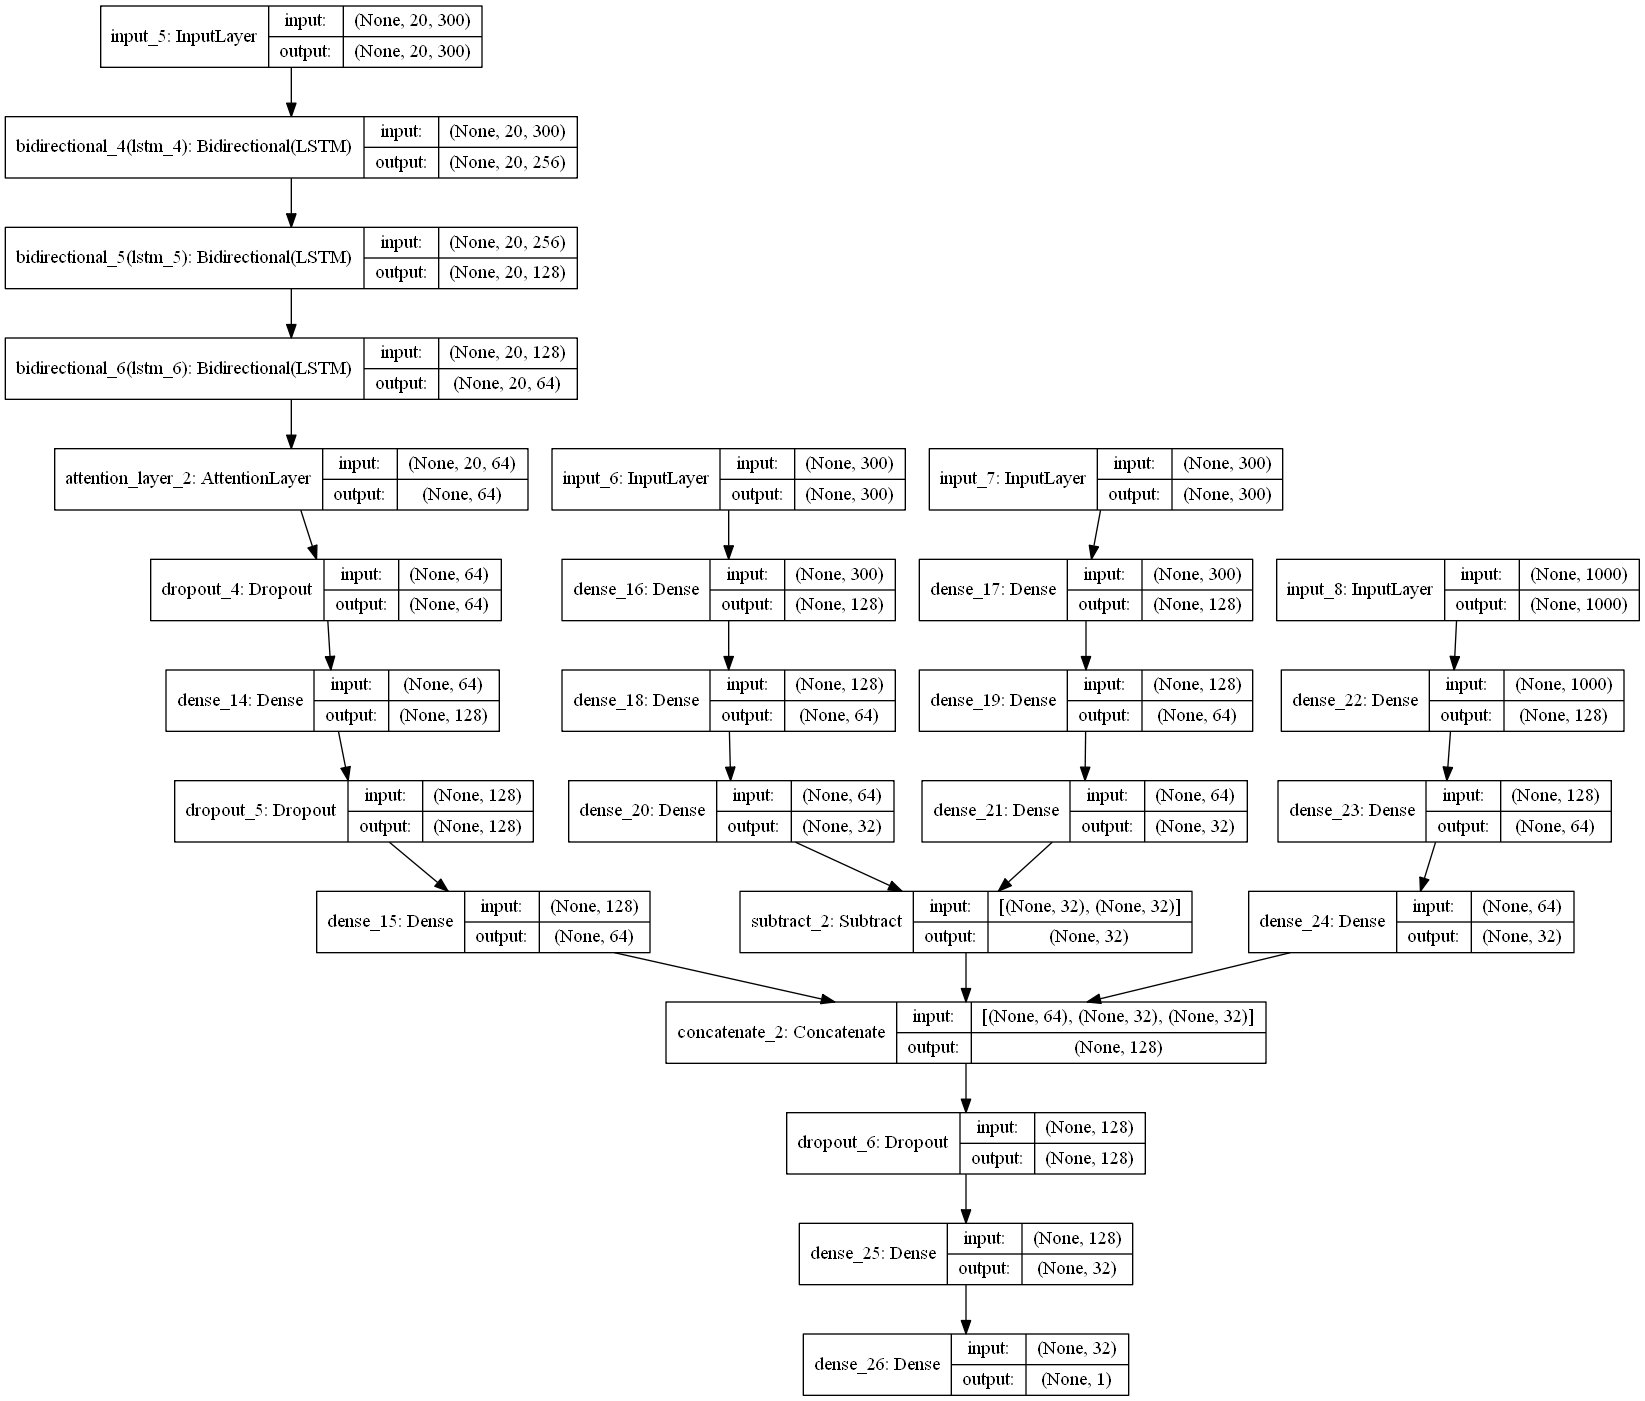

In [74]:
# Plot of the model architecture
plot_model(nfmodels[0]["model"] , show_shapes=True, show_layer_names=True, expand_nested=True, to_file='model.png' )